http://pbpython.com/simple-graphing-pandas.html

https://pandas.pydata.org/pandas-docs/stable/advanced.html

http://seaborn.pydata.org/generated/seaborn.barplot.html

In [123]:
%matplotlib inline

In [124]:
import pandas as pd
import numpy as np
import locale
idx = pd.IndexSlice

In [125]:
#get_ipython().magic('matplotlib inline')

import matplotlib.pylab as plt
import seaborn as sns
from ggplot import *

# import bokeh as bkh
# from bokeh.layouts import row
# from bokeh.plotting import figure, show, output_file

In [126]:
%%time
# dataset from https://www.kaggle.com/kaggle/sf-salaries
# sf2014
sf = pd.read_csv('data/sf-salaries/Salaries.csv', usecols=[0,1,2,3,4,5,6,7,9,11,12], dtype={3: object, 4: object, 5: object, 6: object, 12: object}, na_values=['Not Provided', 'Not provided', 'not provided'])

Wall time: 532 ms


Submission Requirements: 
    
Submit links to a Github repository containing a Jupyter notebook. The notebook should contain:

* The questions you asked
* The trends you investigated
* The resulting visualizations and conclusions.


## Defination of the columns:

### Numeric (needs conversion to numeric):
##### 1. BasePay, OvertimePay, OtherPay, Benefits, TotalPay

### Categorical:
##### 1. Id, EmployeeName, JobTitle, Agency, Status


## Starting Analysis

* Agency - Represents a region in the larger datasets.
* BasePay - The base rate of pay for a job or activity, excluding additional payments such as overtime or bonuses.
* Benefits - Employees pension plan, free health insurance, and other benefits.
* EmployeeName - Full Name (we can try to use this to analyze gender discrimination)
* Id - Original order of employees from sf2014 dataset, field does not exist in sf 2015
* JobTitle - Employee position held. (There seem to be differences in naming between datasets.)
* Notes - Empty
* OtherPay - Not sure but I would imagine Bonuses or other 'special' benefits. Could include personal flights on public aircrafts.
* OvertimePay - Time paid at California's's 1.5x base pay for over time.
* Status - Classification as FT (Full Time) or PT (Part Time) employee. Only tracked after 2013.
* TotalPay - BasePay + OvertimePay + OtherPay
* Year - Payroll year

In [127]:
sf.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,NaN,567595.43,2011,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,2011,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.6,NaN,335279.91,2011,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.0,56120.71,198306.9,NaN,332343.61,2011,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.6,9737.0,182234.59,NaN,326373.19,2011,San Francisco,NaN


In [128]:
sf.isnull().sum()

Id                   0
EmployeeName         6
JobTitle             4
BasePay            609
OvertimePay          4
OtherPay             4
Benefits         36163
TotalPay             0
Year                 0
Agency               0
Status          110535
dtype: int64

In [129]:
sf.Agency.unique()

array(['San Francisco'], dtype=object)

Since the Agency field only contains one unique value, I will remove the field. Notices field is null.

In [130]:
# del sf['Notes']

# Here is another way of dropping a field.

sf.drop(['Agency'], axis=1, inplace=True)

Here I am going to do basic data standardization and cleaning so that it is easier to work with this dataset.

In [131]:
# I am also going to delete any observation where JobTitle is 'Not provided' so that the field can be indexed
sf = sf[sf.JobTitle.notnull()]

# Filling in 'Benefits' if NaN, fill with 0
sf['Benefits'].fillna(0, inplace=True)

# Replace NaN status with "Unknown", since we don't know if its FT or PT work, easier categorization later.
# sf['Status'].fillna("Unknown", inplace=True)

# Convert all JobTitle to upper-case character so there is no differentiation in data.
sf['JobTitle'] = sf.JobTitle.str.upper()

# Convert all EmployeeName to upper-case character so there is no differentiation in data. 
# Note: I noticed in pivots duplicate entries if the letter is not standardized.
sf['EmployeeName'] = sf.EmployeeName.str.upper()

In [132]:
# Much cleaner now
sf.isnull().sum()

Id                   0
EmployeeName         2
JobTitle             0
BasePay            605
OvertimePay          0
OtherPay             0
Benefits             0
TotalPay             0
Year                 0
Status          110531
dtype: int64

NOTE: From reading on the website (where I pulled the dataset) I already saw that there records with zero BasePay, but instead amounts appear in OtherPay and TotalPay, thus 605 null BasePay records does not suprise me.

In [133]:
sf.dtypes

Id                int64
EmployeeName     object
JobTitle         object
BasePay          object
OvertimePay      object
OtherPay         object
Benefits         object
TotalPay        float64
Year              int64
Status           object
dtype: object

Now we need to convert BasePay, OvertimePay, OtherPay, Benefits to a numeric field.

In [134]:
sf.BasePay = sf.BasePay.str.lstrip('$')
sf.OtherPay = sf.OtherPay.str.lstrip('$')
sf.OvertimePay = sf.OvertimePay.str.lstrip('$')
# sf.TotalPay = sf.TotalPay.str.lstrip('$')
sf.Benefits = sf.Benefits.str.lstrip('$')

In [135]:
sf.BasePay = sf.BasePay.str.replace(',','')
sf.OtherPay = sf.OtherPay.str.replace(',','')
sf.OvertimePay = sf.OvertimePay.str.replace(',','')
# sf.TotalPay = sf.TotalPay.str.replace(',','')
sf.Benefits = sf.Benefits.str.replace(',','')

In [136]:
sf.BasePay = pd.to_numeric(sf.BasePay)
sf.OvertimePay = pd.to_numeric(sf['OvertimePay'])
sf.OtherPay = pd.to_numeric(sf['OtherPay'])
sf.Benefits = pd.to_numeric(sf['Benefits'])
sf.TotalPay = pd.to_numeric(sf['TotalPay'])

In [137]:
# sf['BasePay'] = pd.to_numeric(sf['BasePay'])
# sf['OvertimePay'] = pd.to_numeric(sf['OvertimePay'])
# sf['OtherPay'] = pd.to_numeric(sf['OtherPay'])
# sf['Benefits'] = pd.to_numeric(sf['Benefits'])
# sf['TotalPay'] = pd.to_numeric(sf['TotalPay'])

In [138]:
sf.dtypes

Id                int64
EmployeeName     object
JobTitle         object
BasePay         float64
OvertimePay     float64
OtherPay        float64
Benefits        float64
TotalPay        float64
Year              int64
Status           object
dtype: object

Above we can see that the we properly converted the fields to numeric. Now we can do calculations on numeric fields.

In [139]:
sf.describe()

,Id,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year
count,148650.000000,148045.000000,148650.000000,148650.000000,112491.000000,148650.000000,148650.000000
mean,74325.500047,66325.448841,5066.059886,3648.767297,25007.893151,74770.333901,2012.522603
std,42911.703176,42764.635495,11454.380559,8056.601866,15402.215858,50516.196009,1.117526
min,1.000000,-166.010000,-0.010000,-7058.590000,-33.890000,-618.130000,2011.000000
25%,37163.250000,33588.200000,0.000000,0.000000,11535.395000,36169.955000,2012.000000
50%,74325.500000,65007.450000,0.000000,811.270000,28628.620000,71427.240000,2013.000000
75%,111487.750000,94691.050000,4658.175000,4236.065000,35566.855000,105842.960000,2014.000000
max,148654.000000,319275.010000,245131.880000,400184.250000,96570.660000,567595.430000,2014.000000


In [141]:
# sf = sf[sf.BasePay > 0]
# sf = sf[sf.OvertimePay > 0]
# sf = sf[sf.OtherPay > 0]
# sf = sf[sf.TotalPay > 0]

We see that there is some cleaning to do:
1. Remove negative salaries
2. There is some data with null values based on count values

## Years Available in the Dataset

In [142]:
# Min and max in the dataset
print('Min:', sf.Year.min())
print('Max:', sf.Year.max())

Min: 2011
Max: 2014


## Employees per Year

In [143]:
# Count records per year with a loop
for y in range(min(sf.Year), max(sf.Year)+1):
    print(y, (sf.Year == y).sum())

2011 15730
2012 15983
2013 16018
2014 16580


In [144]:
sf.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year,Status
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,2011,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,2011,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,2011,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,2011,NaN
5,6,DAVID SULLIVAN,ASSISTANT DEPUTY CHIEF II,118602.00,8601.00,189082.74,NaN,316285.74,2011,NaN


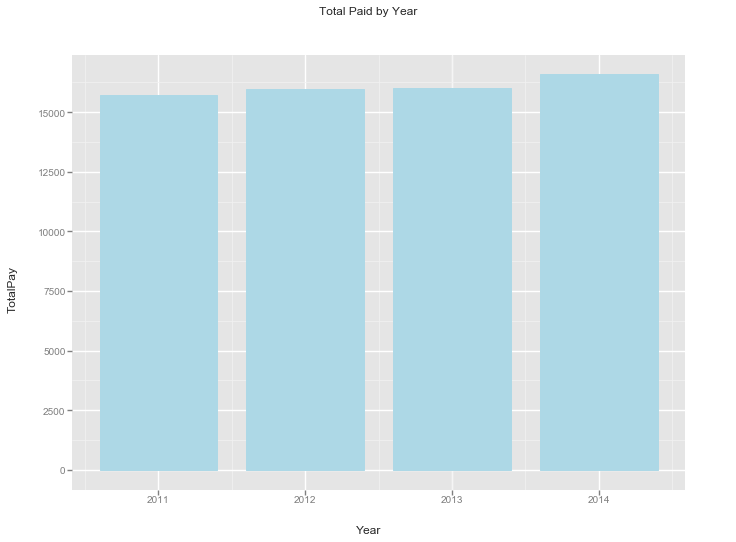

<ggplot: (131102518013)>

In [145]:
ggplot(aes(x='Year', y='TotalPay'), data=sf) +\
    geom_bar(fill='lightblue') +\
    ggtitle("Total Paid by Year")

The salaries seems to have risen only slightly throughout the four years.

In [201]:
# Average Paid by year
sf_yr = sf
sf_yr = sf_yr[['Year', "TotalPay"]].groupby('Year').median()
#sf_yr = sf_yr[['Year', "TotalPay"]].groupby('Year').mean()
sf_yr = sf_yr.unstack().head()
#viz1 = sns.boxplot(x = "Year", y="TotalPay", data = sf)
#viz1 = sns.plt.title('Average Total Paid by Year')
#viz1
#sf_yr.plot(kind='bar')
#sf_yr = sns.barplot(data = sf_yr, x = 'Year', y = 'TotalPay')

ggplot(aes(), data=sf_yr) +\
    geom_boxplot()

TypeError: 'numpy.ndarray' object is not callable

Salaries have not changed much over the years.

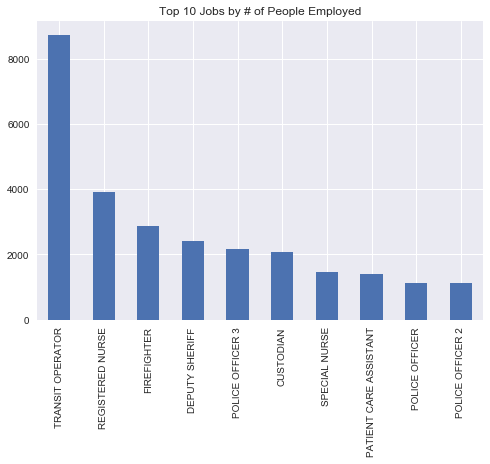

In [35]:
viz2 = sf['JobTitle'].value_counts().head(10)
viz2.plot(title = "Top 10 Jobs by # of People Employed", kind = 'bar')

AttributeError: 'list' object has no attribute 'plot'

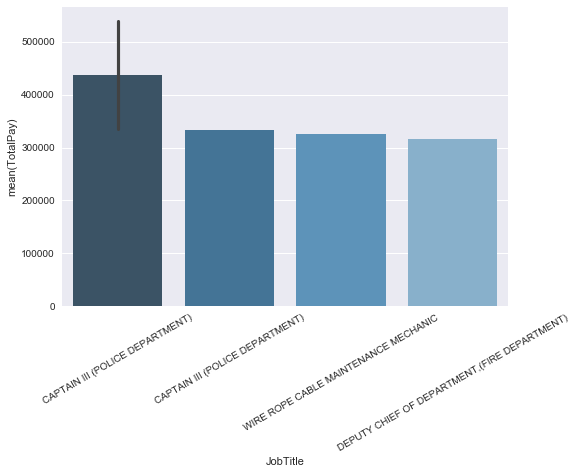

In [56]:
# sf[['Year', "TotalPay"]].groupby('Year').mean()
viz3 = sf[['JobTitle', 'TotalPay']].head()
viz3 = sns.barplot(data = viz3, x = 'JobTitle', y = 'TotalPay', palette="Blues_d")
viz3 = viz3.set_xticklabels(labels=sf['JobTitle'], rotation=30)
viz3.plot(title = "Top 10 Jobs by # of People Employed")

In [91]:
# Create a new column called 'Department'
sf['Department'] = ''

When looking at the 'JobTitles' it is clear that employees can be grouped easily into certain departments such as below:

In [92]:
sf.loc[sf.JobTitle.str.contains('POLICE'), 'Department'] = "POLICE"
sf.loc[sf.JobTitle.str.contains("FIRE"), 'Department'] = "FIRE"
sf.loc[sf.JobTitle.str.contains("MEDICAL"), 'Department'] = "MEDICAL"
sf.loc[sf.JobTitle.str.contains("NURSE"), 'Department'] = "MEDICAL"
sf.loc[sf.JobTitle.str.contains("TRANSIT"), 'Department'] = "TRANSIT"
sf.loc[sf.JobTitle.str.contains("AIRPORT"), 'Department'] = "AIRPORT"
sf.loc[sf.JobTitle.str.contains("WATER"), 'Department'] = "WATER"
sf.loc[sf.Department == '', 'Department'] = 'OTHER'

In [143]:
# Applying $ (currency) for formatting and attractive presentation

ByDepartment = pd.pivot_table(sf, index=['Department'], values=["TotalPay"], aggfunc=[np.sum, np.mean, len], fill_value=0)
ByDepartment.iloc[:,0] = ['${:,.2f} MM'.format(x) for x in ByDepartment.iloc[:,0]/1000000]
ByDepartment.iloc[:,1] = ['${:,.2f}'.format(x) for x in ByDepartment.iloc[:,1]]
ByDepartment

,sum,mean,len
,TotalPay,TotalPay,TotalPay
Department,,,
AIRPORT,$49.75 MM,"$86,214.97",577
FIRE,$845.95 MM,"$158,270.02",5345
MEDICAL,$681.67 MM,"$98,407.36",6927
OTHER,"$2,725.98 MM","$82,763.34",32937
POLICE,$931.94 MM,"$130,341.83",7150
TRANSIT,$829.02 MM,"$75,427.52",10991
WATER,$34.62 MM,"$90,166.50",384


In the above table we can see the total, mean and count of Total Paid per Department

# Average Salary by Department

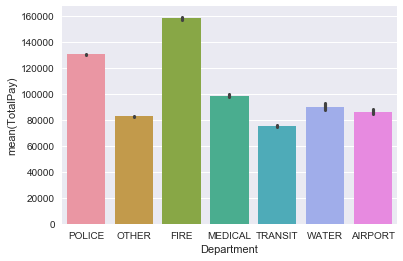

In [94]:
sns.barplot(x = "Department", y = "TotalPay", data = sf)

# Distribution of Salary by Department

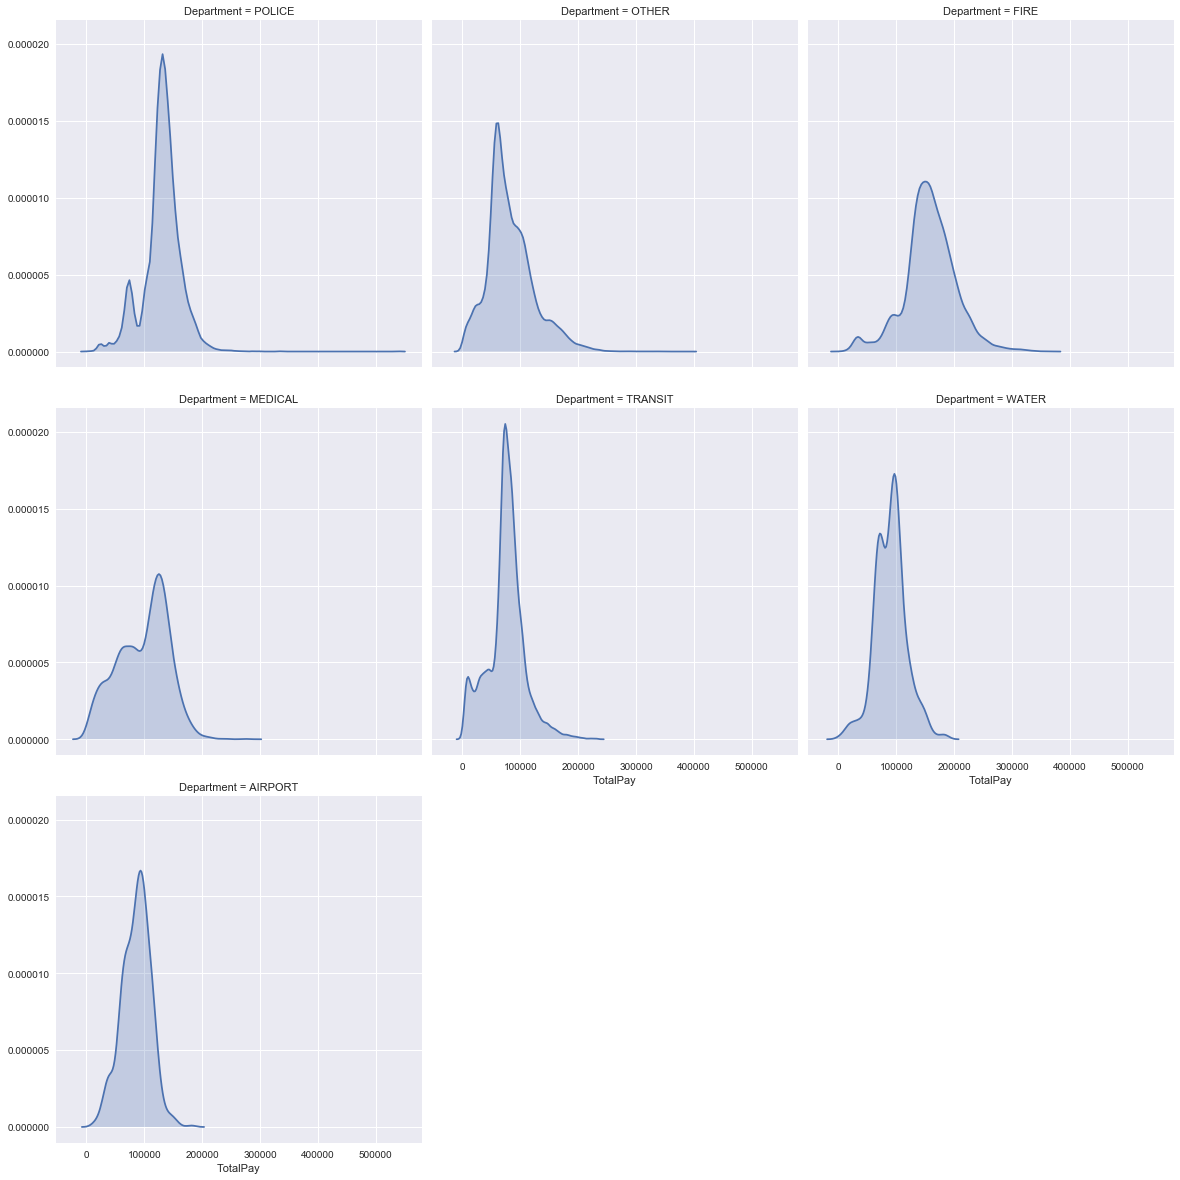

In [95]:
plot_jg = sns.FacetGrid(sf, col="Department", col_wrap=3, size=5.5, dropna=True)
plot_jg = plot_jg.map(sns.kdeplot, 'TotalPay', shade=True)

# Salaries by Year

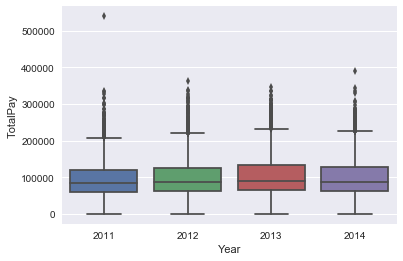

In [96]:
sns.boxplot(x="Year", y="TotalPay", data=sf)

Above we see that the salaries have not changed between the years.

# Gender Pay Gap

In [97]:
# from https://pypi.python.org/pypi/gender-guesser
import gender_guesser.detector as gender

In [98]:
d = gender.Detector(case_sensitive=False)

In [99]:
sf['FirstName'] = sf.EmployeeName.str.split(' ').str.get(0)
sf['FirstName']= sf.FirstName.str.lower()
sf.FirstName.fillna(method="backfill", inplace=True)

In [100]:
gender = []
names = []

for i in range(0, len(sf.FirstName)):
    names.append(sf.FirstName.iloc[i])
    gender.append(d.get_gender(sf.FirstName.iloc[i]))

In [102]:
# Create gender dataset

dict_gender = dict(zip(names, gender))
df_gender = pd.DataFrame()
df_gender['FirstName'] = dict_gender.keys()
df_gender['Gender'] = dict_gender.values()
sf_gender = pd.merge(sf, df_gender, how='left')
sf_gender.head(10)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year,Status,Department,FirstName,Gender
0,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,2011,NaN,POLICE,gary,male
1,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,2011,NaN,POLICE,albert,male
2,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,2011,NaN,OTHER,christopher,male
3,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,2011,NaN,FIRE,patrick,male
4,6,DAVID SULLIVAN,ASSISTANT DEPUTY CHIEF II,118602.00,8601.00,189082.74,NaN,316285.74,2011,NaN,OTHER,david,male
5,7,ALSON LEE,"BATTALION CHIEF, (FIRE DEPARTMENT)",92492.01,89062.90,134426.14,NaN,315981.05,2011,NaN,FIRE,alson,unknown
6,9,MICHAEL MORRIS,"BATTALION CHIEF, (FIRE DEPARTMENT)",176932.64,86362.68,40132.23,NaN,303427.55,2011,NaN,FIRE,michael,male
7,11,ARTHUR KENNEY,"ASSISTANT CHIEF OF DEPARTMENT, (FIRE DEPARTMENT)",194999.39,71344.88,33149.90,NaN,299494.17,2011,NaN,FIRE,arthur,male
8,12,PATRICIA JACKSON,CAPTAIN III (POLICE DEPARTMENT),99722.00,87082.62,110804.30,NaN,297608.92,2011,NaN,POLICE,patricia,female
9,15,DAVID FRANKLIN,"BATTALION CHIEF, (FIRE DEPARTMENT)",174872.64,74050.30,37424.11,NaN,286347.05,2011,NaN,FIRE,david,male


In [144]:
# Clean up the genders to fall into categories

sf_gender.loc[sf_gender['Gender'] == 'andy', 'Gender'] = 'unknown'
sf_gender.loc[sf_gender['Gender'] == 'mostly_female', 'Gender'] = 'female'
sf_gender.loc[sf_gender['Gender'] == 'mostly_male', 'Gender'] = 'male'
sf_gender.head(10)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year,Status,Department,FirstName,Gender
0,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,2011,NaN,POLICE,gary,male
1,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,2011,NaN,POLICE,albert,male
2,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,2011,NaN,OTHER,christopher,male
3,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,2011,NaN,FIRE,patrick,male
4,6,DAVID SULLIVAN,ASSISTANT DEPUTY CHIEF II,118602.00,8601.00,189082.74,NaN,316285.74,2011,NaN,OTHER,david,male
5,7,ALSON LEE,"BATTALION CHIEF, (FIRE DEPARTMENT)",92492.01,89062.90,134426.14,NaN,315981.05,2011,NaN,FIRE,alson,unknown
6,9,MICHAEL MORRIS,"BATTALION CHIEF, (FIRE DEPARTMENT)",176932.64,86362.68,40132.23,NaN,303427.55,2011,NaN,FIRE,michael,male
7,11,ARTHUR KENNEY,"ASSISTANT CHIEF OF DEPARTMENT, (FIRE DEPARTMENT)",194999.39,71344.88,33149.90,NaN,299494.17,2011,NaN,FIRE,arthur,male
8,12,PATRICIA JACKSON,CAPTAIN III (POLICE DEPARTMENT),99722.00,87082.62,110804.30,NaN,297608.92,2011,NaN,POLICE,patricia,female
9,15,DAVID FRANKLIN,"BATTALION CHIEF, (FIRE DEPARTMENT)",174872.64,74050.30,37424.11,NaN,286347.05,2011,NaN,FIRE,david,male


In [146]:
# Create index for further analysis.

sf_gender.set_index(['Year', 'Department', 'Gender']).sort_index().head()

Id      EmployeeName  \
Year Department Gender                           
2011 AIRPORT    female  7437      DIAN STAVREV   
                female  7683  MARGARETE CABATU   
                female  9041      BRANDI BENAS   
                female  9273       EVA POLLITT   
                female  9795    SHANNON WILSON   

                                                        JobTitle   BasePay  \
Year Department Gender                                                       
2011 AIRPORT    female                       AIRPORT ELECTRICIAN  95275.80   
                female  SENIOR AIRPORT COMMUNICATIONS DISPATCHER  79987.82   
                female           AIRPORT COMMUNICATIONS OPERATOR  73255.90   
                female           AIRPORT COMMUNICATIONS OPERATOR  73008.21   
                female             AIRPORT OPERATIONS SUPERVISOR  90360.49   

                        OvertimePay  OtherPay  Benefits   TotalPay Status  \
Year Department Gender                                                      
2011 AIRPORT    female     11686.26   3910.31       NaN  110872.37    NaN   
                female     23073.50   6116.48       NaN  109177.80    NaN   
                female     23634.46   5619.12       NaN  102509.48    NaN   
                female     23981.23   4372.03       NaN  101361.47    NaN   
                female      6996.45   1058.52       NaN   98415.46    NaN   

                        FirstName  
Year Department Gender             
2011 AIRPORT    female       dian  
                female  margarete  
                female     brandi  
                female        eva  
                female    shannon

# Count by Gender and Department

In [105]:
dept_gender = sf_gender.groupby(['Gender', 'Department']).size().unstack()
dept_gender

Department,AIRPORT,FIRE,MEDICAL,OTHER,POLICE,TRANSIT,WATER
Gender,,,,,,,
female,173,786,4332,8499,1108,1868,51
male,350,4294,1383,19714,5637,7286,294
unknown,54,265,1212,4724,405,1837,39


Here we can see that there are significantly less female's on the job except in the MEDICAL profession.

In [147]:
a = sf_gender[['JobTitle', 'Gender', 'TotalPay']]
a = a.set_index(['Gender', 'JobTitle'], append=True)
a = a.unstack('Gender')
b = a.TotalPay.median(level=1)
b['Diff'] = b.female / b.male
b = b[b.Diff.notnull()]
b.mean()

Gender
female     87498.705639
male       90199.490470
unknown    86591.196502
Diff           1.016004
dtype: float64

Above we can see that the difference of median salaries is 1%

In [148]:
a = sf_gender[['JobTitle', 'Gender', 'TotalPay']]
a = a.set_index(['Gender', 'JobTitle'], append=True)
a = a.unstack('Gender')
b = a.TotalPay.mean(level=1)
b['Diff'] = b.female / b.male
b = b[b.Diff.notnull()]
b.mean()

Gender
female     85832.550795
male       88834.021501
unknown    85119.118760
Diff           0.995724
dtype: float64

Above we can see that the difference of mean salaries is less than 1%

# Mean pay by Department and Gender Barplot

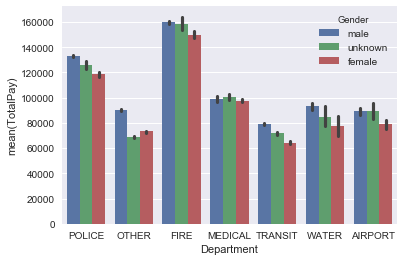

In [149]:
sns.barplot(data=sf_gender, x='Department', y='TotalPay', hue='Gender')

There are certain profession that men do seem to earn more than woman, however, if you look at the mean and median of all differences the difference does not seem to be significant.

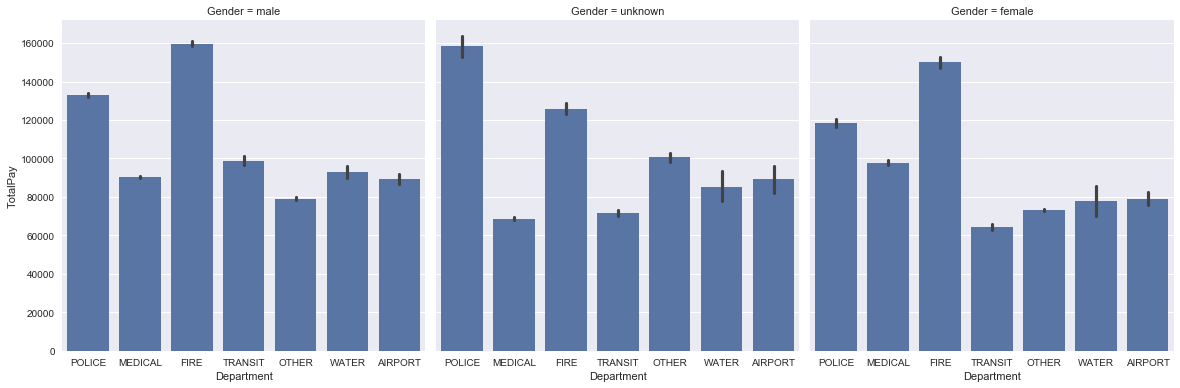

In [112]:
plot_gen = sns.FacetGrid(sf_gender, col="Gender", col_wrap=3, size=5.5, dropna=True)
plot_gen = plot_gen.map(sns.barplot, 'Department', 'TotalPay')

In [ ]:
# How have salaries changed over time between different groups of people?

In [ ]:
# How are base pay, overtime pay and benefits allocated between different groups?

In [ ]:
# Is there any evidene of pay discrimination based on gender in this dataset?

# !!! I AM STRUGGLING SELECTING THE FIRST COLUMN HERE. !!!

In [140]:
c = sf_gender[['Department', 'Gender', 'TotalPay']]
c = c[c.Gender != 'unknown']
c = c.set_index(['Gender', 'Department'], append=True)
c = c.unstack('Gender')
c = c.TotalPay.mean(level=1)
c['Diff'] = c.female / c.male
c = c[c.Diff.notnull()]
#c = sns.barplot(data = c, x = 'Department', y = 'TotalPay')
c

Gender,female,male,Diff
Department,,,
AIRPORT,78908.031676,89321.222486,0.883419
FIRE,150011.716743,159751.367089,0.939032
MEDICAL,97633.275226,98714.565177,0.989046
OTHER,73218.804126,90245.954559,0.811325
POLICE,118534.132310,132977.259684,0.891386
TRANSIT,64349.281162,79178.455913,0.812712
WATER,77708.459216,93011.041837,0.835476


In [56]:
# How is budget allocated based on different groups and responsibilities?

## Questions to Explore

In [33]:
# Are there any duplicate names in the dataset?

In [34]:
# Which employee has been employed three years?

In [35]:
# What is the correlation between titles and salaries?